# Online Gradient Boosting Decision Tree (OnlineGBDT) Demo
This notebook shows how to train, update, and evaluate the custom `DecisionTree` and `OnlineGBDT` classes.

👉 *Make sure the module that defines `DecisionTree` and `OnlineGBDT` is importable (e.g. saved as **`online_gbdt.py`** in the same folder or installed as a package).*

In [1]:
import os
import sys

# Get the current working directory
current_directory = os.getcwd()

# List all files and directories in the current directory
files_and_directories = os.listdir(current_directory)

# Print the list of files and directories
print("Files and directories in the current directory:")
for item in files_and_directories:
    print(item)


Files and directories in the current directory:
online_gbdt_demo.ipynb


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from fogo.online_gbdt import OnlineGBDT  # or paste the class definitions here

In [3]:
# Create a simple synthetic regression dataset
np.random.seed(42)
N = 200
X = np.random.randn(N, 5)
true_coef = np.array([3, -2, 0, 1, 2])
y = X @ true_coef + np.random.randn(N) * 0.5
print('Dataset shape:', X.shape)

Dataset shape: (200, 5)


In [4]:
# Train the gradient‑boosting ensemble
model = OnlineGBDT(n_estimators=10, learning_rate=0.1, max_depth=10)
model.fit(X, y)
print('Initial training complete.')

Initial training complete.


**Experiment:** prototype a Grid-search like algorithm to find the optimal hyperparameter combination.

If the MSE is still awful then try checking the model architecture.

In [6]:
from itertools import product
from sklearn.metrics import mean_squared_error
# import train test split package
from sklearn.model_selection import train_test_split
import numpy as np

# split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [10, 25, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 5, 10],
}

best_params = None
best_score = float('inf')

for n, lr, d in product(param_grid['n_estimators'],
                        param_grid['learning_rate'],
                        param_grid['max_depth']):

    print(f"Training with n_estimators={n}, learning_rate={lr}, max_depth={d}")
    
    model = OnlineGBDT(n_estimators=n, learning_rate=lr, max_depth=d)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)

    print(f"Mean Squared Error: {mse:.4f}")
    
    if mse < best_score:
        best_score = mse
        best_params = {'n_estimators': n, 'learning_rate': lr, 'max_depth': d}

print(f"✅ Best MSE: {best_score:.4f} with {best_params}")

Training with n_estimators=10, learning_rate=0.01, max_depth=2


Mean Squared Error: 12.9118
Training with n_estimators=10, learning_rate=0.01, max_depth=5
Mean Squared Error: 12.1519
Training with n_estimators=10, learning_rate=0.01, max_depth=10
Mean Squared Error: 12.0505
Training with n_estimators=10, learning_rate=0.05, max_depth=2
Mean Squared Error: 9.7655
Training with n_estimators=10, learning_rate=0.05, max_depth=5
Mean Squared Error: 7.3616
Training with n_estimators=10, learning_rate=0.05, max_depth=10
Mean Squared Error: 7.5040
Training with n_estimators=10, learning_rate=0.1, max_depth=2
Mean Squared Error: 7.4450
Training with n_estimators=10, learning_rate=0.1, max_depth=5
Mean Squared Error: 4.5045
Training with n_estimators=10, learning_rate=0.1, max_depth=10
Mean Squared Error: 5.6823
Training with n_estimators=25, learning_rate=0.01, max_depth=2
Mean Squared Error: 11.6458
Training with n_estimators=25, learning_rate=0.01, max_depth=5
Mean Squared Error: 9.9825
Training with n_estimators=25, learning_rate=0.01, max_depth=10
Mean 

In [7]:
model = OnlineGBDT(n_estimators=best_params['n_estimators'],
                   learning_rate=best_params['learning_rate'],
                   max_depth=best_params['max_depth'])

model.fit(X_train, y_train)
print(f"Training completed with best parameters: {best_params}")

Training completed with best parameters: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 2}


I'm honestly deeply concerned about how poorly this ensemble performs lmao. Can we try to add more layers?

In [8]:
# Evaluate training MSE
pred = model.predict(X)
mse = np.mean((y - pred) ** 2)
print(f'Mean squared error: {mse:.4f}')

Mean squared error: 0.9487


In [9]:
# --- Incremental learning example (fit_one) ---
x_new = np.random.randn(5)
y_new = x_new @ true_coef + np.random.randn() * 0.5
print('Prediction before update:', model.predict([x_new])[0])
model.fit_one(x_new, y_new)
print('Prediction after update :', model.predict([x_new])[0])

Prediction before update: 1.535196677899395
Prediction after update : 1.5388026971752407


In [10]:
# --- Decremental learning example ---
residual = y_new - model.predict([x_new])[0]
model.decrement(x_new, residual)
print('Prediction after decrement:', model.predict([x_new])[0])

Prediction after decrement: -0.24617684436838352


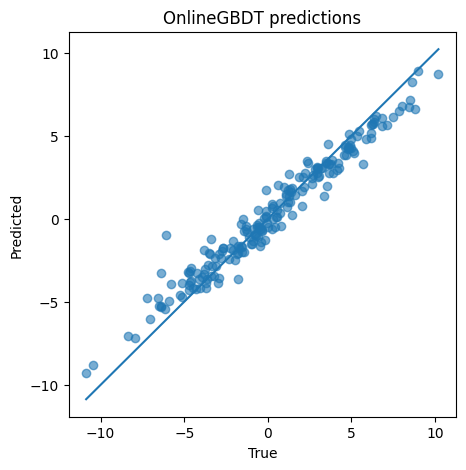

In [11]:
# Visualise predictions vs. ground truth
plt.figure(figsize=(5,5))
plt.scatter(y, pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('OnlineGBDT predictions')
plt.show()